In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

# Data

In [2]:
P01 = 160            #kPa

In [3]:
T01 = 400            #kelvin

In [4]:
P_N = 100            #kPa

In [5]:
gama = 1.4
R = 0.287            #kj/kg-k
C_v = 0.717          #kj/kg-k

In [6]:
rho01 = P01/(R*T01)

In [7]:
L1 = 3       #meter
L2 = 1       #meter
L3 = 5       #meter

In [8]:
D1 = 0.2     #meter
D3 = 0.1     #meter

# Grid Points

In [9]:
dx = 0.1                                        #meter
x1 = np.linspace(0, L1, int(L1/dx+1))
x2 = np.linspace(L1, L1+L2, int(L2/dx+1))
x3 = np.linspace(L1+L2, L1+L2+L3, int(L3/dx+1))

In [10]:
N = int(L1/dx+1)+int(L2/dx+1)+int(L3/dx+1)-2                     #Number of Grid Points

In [11]:
N

91

In [12]:
x = np.array(list(x1)+list(x2[1:])+list(x3[1:]), dtype=float)

In [13]:
A = np.zeros(len(x))

In [14]:
for i in range(0, len(x)):
    
    if x[i] <= L1:
        
        A[i] = math.pi*D1**2/4
        
    elif x[i] <= L1+L2:
        
        D2 = (x[i]-L1)/L2*(D3-D1)+D1
        A[i] = math.pi*D2**2/4
        
    else:
        
        A[i] = math.pi*D3**2/4

# suddenly

In [15]:
data = pd.read_excel('steady.xlsx')

In [16]:
#primitive variables at t = 0:
rho_n = np.array(data['rho'])
v_n = np.array(data['v'])
T_n = np.array(data['T'])
P_n = rho_n*T_n

CFL = 0.6

n = np.where(x == L1+L2)[0][0]          #index for throat
A = A/A[n]
iteration = 1

#dU1/dt, dU2/dt, dU3/dt:
dU1_dt = np.ones(len(x))
dU2_dt = np.ones(len(x))
dU3_dt = np.ones(len(x))

#(dU1/dt)_bar, (dU2/dt)_bar:, (dU3/dt)_bar:
dU1_dt_bar = np.ones(len(x))
dU2_dt_bar = np.ones(len(x))
dU3_dt_bar = np.ones(len(x))

In [ ]:
# Set up the initial plot
fig, ax = plt.subplots()
mass_flux_nd = [rho_n[n]*v_n[n]]
time = [0]
P_nd = [P_n[n]]
line1, = ax.plot(time, mass_flux_nd)
ax.set_xlabel('time')
ax.set_ylabel('Non-Dimensional Mass Flux')
ax.set_title('Live Mass Flux')
m_dot = 1
t = 0

while (m_dot>0.01):
    
    print(f'this is iteration = {iteration}')
    dt = np.min(CFL*dx/((gama*R*1000*abs(T_n)*T01)**0.5+abs(v_n)*(gama*R*1000*T01)**0.5))
    t += dt
    
    if np.isnan(dt):
        
        break
    #dt = 0.000015
    print(f'dt = {dt}')

    #U1, U2, U3:
    U1 = rho_n*A
    U2 = rho_n*v_n*A
    U3 = rho_n*(T_n/(gama-1)+gama/2*v_n**2)*A

    #F1, F2, F3:
    F1 = U2
    F2 = U2**2/U1+(gama-1)/gama*(U3-gama/2*U2**2/U1)
    F3 = gama*U2*U3/U1-gama*(gama-1)/2*U2**3/U1**2
    J2 = (gama-1)/gama*(U3-gama/2*U2**2/U1)*math.pi/2*A*(D3-D1)/L2

    for i in range(0, len(x)-1):
    
        dU1_dt[i] = -(F1[i+1]-F1[i])/dx
        dU2_dt[i] = -(F2[i+1]-F2[i])/dx+J2[i]
        dU3_dt[i] = -(F3[i+1]-F3[i])/dx
        
    #print(f'dU1_dt_bar = {dU1_dt[i]}')
    
    #U1_np1_bar, U1_np1_bar, U1_np1_bar:    np1: n+1
    U1_np1_bar = U1+dU1_dt*dt
    U2_np1_bar = U2+dU2_dt*dt
    U3_np1_bar = U3+dU3_dt*dt    

    #primitive variables:
    rho_bar = U1_np1_bar/A
    v_bar = U2_np1_bar/U1_np1_bar
    T_bar = (gama-1)*(U3_np1_bar/U1_np1_bar-gama/2*v_bar**2)
    P_bar = rho_bar*T_bar

    #F1_bar, F2_bar, F3_bar, J2_bar:
    F1_bar = U2_np1_bar
    F2_bar = U2_np1_bar**2/U1_np1_bar+(gama-1)/gama*(U3_np1_bar-gama/2*U2_np1_bar**2/U1_np1_bar)
    F3_bar = gama*U2_np1_bar*U3_np1_bar/U1_np1_bar-gama*(gama-1)/2*U2_np1_bar**3/U1_np1_bar**2
    J2_bar = (gama-1)/gama*(U3_np1_bar-gama/2*U2_np1_bar**2/U1_np1_bar)*math.pi/2*A*(D3-D1)/L2

    for i in range(1, len(x)):
    
        dU1_dt_bar[i] = -(F1_bar[i]-F1_bar[i-1])/dx
        dU2_dt_bar[i] = -(F2_bar[i]-F2_bar[i-1])/dx+J2_bar[i]
        dU3_dt_bar[i] = -(F3_bar[i]-F3_bar[i-1])/dx
        
    print(f'dU1_dt_bar = {dU1_dt_bar[i]}')
    
    #average of time derivatives:
    dU1_dt_avg = 0.5*(dU1_dt_bar+dU1_dt)
    dU2_dt_avg = 0.5*(dU2_dt_bar+dU2_dt)
    dU3_dt_avg = 0.5*(dU3_dt_bar+dU3_dt)

    #U1_np1, U1_np2, U1_np3
    U1_np1 = U1+dU1_dt_avg*dt
    U2_np1 = U2+dU2_dt_avg*dt
    U3_np1 = U3+dU3_dt_avg*dt

    #decoding primitive variables:
    rho_np1 = U1_np1/A
    v_np1 = U2_np1/U1_np1
    T_np1 = (gama-1)*(U3_np1/U1_np1-gama/2*(U2_np1/U1_np1)**2)
    P_np1 = rho_np1*T_np1
    
    #subsonic inlet:
    P_np1[0] = P01/P01
    T_np1[0] = T01/T01
    a = (gama*R*1000*T_np1[0]*T01)
    v_np1[0] = v_n[0]+dt*a*v_n[0]*math.log(A[1]/A[0])
    rho_np1[0] = P_np1[0]/T_np1[0]
 
    #outlet:
    P_np1[N-1] = 0.1*(math.e)**(-t)
    
    #residuals:
    drho_dt_avg = abs((rho_np1[n]-rho_n[n])/dt)
    dv_dt_avg = abs((v_np1[n]-v_n[n])/dt)
    dT_dt_avg = abs((T_np1[n]-T_n[n])/dt)
    
    rho_n = rho_np1.copy()
    v_n = v_np1.copy()    
    T_n = T_np1.copy() 
    P_n = P_np1.copy()
    
    #delta_m_dot
    m_dot = rho_n[n]*v_n[n]
    print(f'nd mass flux = {m_dot}')
    
    # Append the current iteration number and residual values to the x and y arrays
    mass_flux_nd.append(m_dot)
    time.append(t)
    P_nd.append(P_n[n])
    
    line1.set_data(time, mass_flux_nd)
    ax.relim()
    ax.autoscale_view()
    
    # Update and display the plot after each iteration
    clear_output(wait=True)
    display(fig)
    plt.pause(0.001)
    
    iteration += 1
        
    #if iteration==20000:
        #break
# Show the final plot after all iterations are completed
plt.show()

Text(0, 0.5, 'Non-Dimensional Mass Flux')

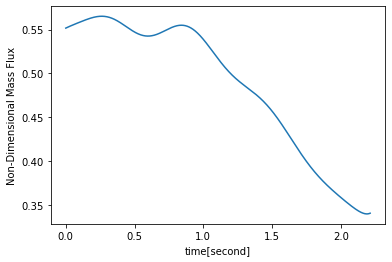

In [18]:
plt.plot(time, mass_flux_nd, linestyle = "solid")
plt.xlabel('time[second]')
plt.ylabel('Non-Dimensional Mass Flux')

Text(0, 0.5, 'Non-Dimensional Pressure')

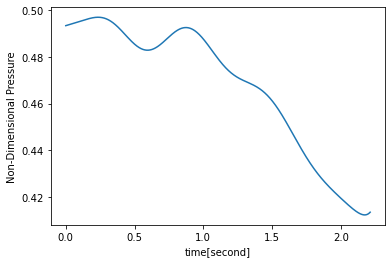

In [19]:
plt.plot(time, P_nd, linestyle = "solid")
plt.xlabel('time[second]')
plt.ylabel('Non-Dimensional Pressure')